In [1]:
# Change directory
import os
os.chdir("..")

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from raw_slope_functions import calculate_slopes_se, run_ttest
from window_extraction import calculate_window_values, calculate_window_data, Merge_data, align_to_zero, balance_index
from time_series_visualization import plot_all_time_series, plot_all_time_series_and_mean_fpca, plot_all_time_series_in_group
from functionalPCA import fpca_two_inputs, first_component_extraction, bootstrap, create_pc_scores_plots, visualize_regression
from functional_regression import Function_regression, coefficent_visualization

In [3]:
# import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv")

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

In [7]:
# Sensor A System 1
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# Sensor A System 2
calDelimit = 9.6
cal_window_size = 8
sampleDelimit = 17.2
sample_window_size = 5

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# sensor B

# For sensor B in system 1, blood and aqueous

calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous

calDelimit = 18
cal_window_size = 18
sampleDelimit_blood = 30.4
sampleDelimit_aqueous = 32.8
sample_window_size = 4

B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))


In [8]:
# extract window data for sensor A in system 1
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)
A1_cal_window.dropna(inplace=True)
A1_sample_window.dropna(inplace=True)

# extract window data for sensor A in system 2
A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)
A2_cal_window.dropna(inplace=True)
A2_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 1
B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID']
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)
B1_cal_window.dropna(inplace=True)
B1_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 2
B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID']
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)
B2_cal_window.dropna(inplace=True)
B2_sample_window.dropna(inplace=True)


In [9]:
# Merge attributes with extracted cal and sample window

# Sensor A
A1_attributes = A1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A1_cal_window = A1_cal_window.reset_index()
A1_cal_window_binned = A1_attributes.merge(A1_cal_window, how = "inner", on = "TestID")
A1_sample_window = A1_sample_window.reset_index()
A1_sample_window_binned = A1_attributes.merge(A1_sample_window, how = "inner", on = "TestID")

A2_attributes = A2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A2_cal_window = A2_cal_window.reset_index()
A2_cal_window_binned = A2_attributes.merge(A2_cal_window, how = "inner", on = "TestID")
A2_sample_window = A2_sample_window.reset_index()
A2_sample_window_binned = A2_attributes.merge(A2_sample_window, how = "inner", on = "TestID")

# Sensor B
B1_attributes = B1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B1_cal_window = B1_cal_window.reset_index()
B1_cal_window_binned = B1_attributes.merge(B1_cal_window, how = "inner", on = "TestID")
B1_sample_window = B1_sample_window.reset_index()
B1_sample_window_binned = B1_attributes.merge(B1_sample_window, how = "inner", on = "TestID")

B2_attributes = B2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B2_cal_window = B2_cal_window.reset_index()
B2_cal_window_binned = B2_attributes.merge(B2_cal_window, how = "inner", on = "TestID")
B2_sample_window = B2_sample_window.reset_index()
B2_sample_window_binned = B2_attributes.merge(B2_sample_window, how = "inner", on = "TestID")

In [10]:
# Calculate sample size for each system and sensors calibration and sample window
N_A1_cal = A1_cal_window.shape[1]
N_A2_cal = A2_cal_window.shape[1]
N_A1_sample = A1_sample_window.shape[1]
N_A2_sample = A2_sample_window.shape[1]

N_B1_cal = B1_cal_window.shape[1]
N_B2_cal = B2_cal_window.shape[1]
N_B1_sample = B1_sample_window.shape[1]
N_B2_sample = B2_sample_window.shape[1]

# **Fluid Type**

## **Sensor A**

In [11]:
# Slopes
labels = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5', 'AB', 'HNB', 'NB', 'SB-3', 'DB', 'TB11', 'SB']
A1_cal = calculate_slopes_se(A1_cal_window_binned, "FluidType", labels)
A1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

A1_sample = calculate_slopes_se(A1_sample_window_binned, "FluidType", labels)
A1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

A2_cal = calculate_slopes_se(A2_cal_window_binned, "FluidType", labels)
A2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

A2_sample = calculate_slopes_se(A2_sample_window_binned, "FluidType", labels)
A2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_A_slopes = pd.concat([A1_cal, A2_cal, A1_sample, A2_sample],axis = 1)
Sensor_A_slopes.index = labels
Sensor_A_slopes

/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slopes.append(model.params[1])
/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std.append(model.bse[1])
/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Eurotrol L1,0.010366,0.000017,0.007830,0.000027,-0.000630,0.000138,0.004902,0.000064
Eurotrol L3,0.010634,0.000021,0.008369,0.000026,-0.000628,0.000166,0.004172,0.000067
Eurotrol L4,0.021483,0.000037,0.022512,0.000023,0.004963,0.000167,0.016339,0.000057
Eurotrol L5,0.012007,0.000026,0.005656,0.000030,-0.001689,0.000191,0.001824,0.000055
AB,-0.006141,0.000017,-0.007563,0.000047,-0.010200,0.000083,-0.007812,0.000045
HNB,0.017347,0.000035,0.014675,0.000122,0.006471,0.000159,0.012142,0.000085
NB,0.020807,0.000038,0.022737,0.000018,0.008606,0.000165,0.017636,0.000086
SB-3,0.015295,0.000030,0.018566,0.000043,0.000434,0.000100,0.004612,0.000132
DB,0.022293,0.000040,0.022598,0.000013,0.015647,0.000288,0.030677,0.000099
TB11,0.021898,0.000046,0.024604,0.000029,0.011716,0.000106,0.020602,0.000100


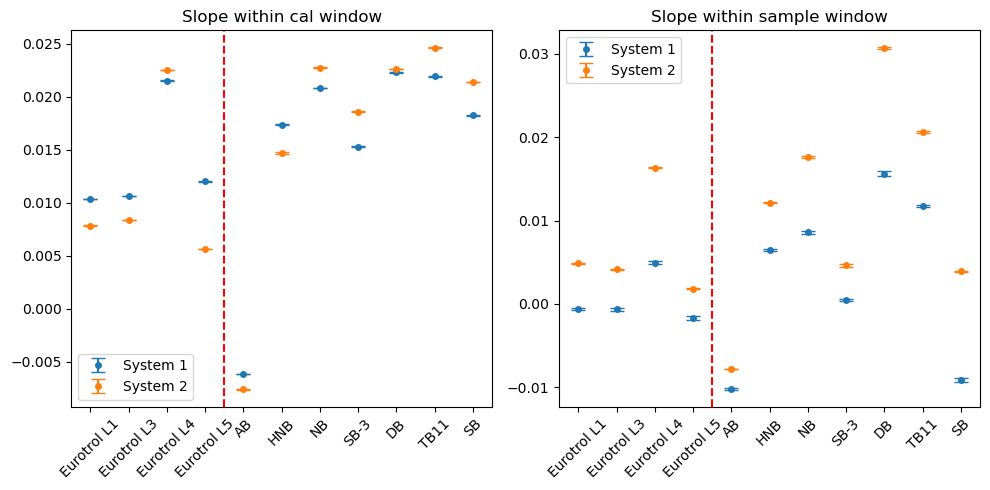

In [12]:
# Plot of slopes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-1-cal-slope"], yerr=Sensor_A_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-2-cal-slope"], yerr=Sensor_A_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-1-sample-slope"], yerr=Sensor_A_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-2-sample-slope"], yerr=Sensor_A_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

for ax in axes:
    ax.axvline(x=3.5, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [13]:
# T-tests to compare slopes in each bin
ttest_A = run_ttest(Sensor_A_slopes, N_A1_cal, N_A2_cal, N_A1_sample, N_A2_sample, labels)
ttest_A

/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stat_cal = (data["System-1-cal-slope"][i] - data["System-2-cal-slope"][i]) / np.sqrt(data["System-1-cal-se"][i]**2 + data["System-2-cal-se"][i]**2)
/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stat_sample = (data["System-1-sample-slope"][i] - data["System-2-sample-slope"][i]) / np.sqrt(data["System-1-sample-se"][i]**2 + data["Sys

,t-statistic-cal,p-value-cal,t-statistic-sample,p-value-sample
Eurotrol L1,78.287411,0.000000e+00,-36.321266,0.0
Eurotrol L3,67.716335,0.000000e+00,-26.889227,0.0
Eurotrol L4,-23.684122,0.000000e+00,-64.511091,0.0
Eurotrol L5,159.329277,0.000000e+00,-17.692124,0.0
AB,28.566869,0.000000e+00,-25.397179,0.0
HNB,21.121047,0.000000e+00,-31.532622,0.0
NB,-45.745343,0.000000e+00,-48.600346,0.0
SB-3,-62.828419,0.000000e+00,-25.268370,0.0
DB,-7.277917,1.845180e-10,-49.336190,0.0
TB11,-49.941835,0.000000e+00,-61.230564,0.0


## **Sensor B**

In [14]:
# Slopes
labels = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5', 'AB', 'HNB', 'NB', 'SB-3', 'DB', 'TB11', 'SB']
B1_cal = calculate_slopes_se(B1_cal_window_binned, "FluidType", labels)
B1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

B1_sample = calculate_slopes_se(B1_sample_window_binned, "FluidType", labels)
B1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

B2_cal = calculate_slopes_se(B2_cal_window_binned, "FluidType", labels)
B2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

B2_sample = calculate_slopes_se(B2_sample_window_binned, "FluidType", labels)
B2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_B_slopes = pd.concat([B1_cal, B2_cal, B1_sample, B2_sample],axis = 1)
Sensor_B_slopes.index = labels
Sensor_B_slopes

/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slopes.append(model.params[1])
/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std.append(model.bse[1])
/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Eurotrol L1,0.036585,0.000035,0.044068,0.000047,0.050204,0.000292,0.052587,0.000219
Eurotrol L3,0.036775,0.000036,0.044670,0.000048,0.035858,0.000141,0.042694,0.000121
Eurotrol L4,0.037097,0.000048,0.042372,0.000058,0.049011,0.000297,0.049599,0.000222
Eurotrol L5,0.038749,0.000044,0.045861,0.000049,-0.008749,0.000366,0.025336,0.000248
AB,0.043204,0.000020,0.047686,0.000038,0.051884,0.000192,0.048897,0.000119
HNB,0.038287,0.000045,0.044808,0.000087,0.042657,0.000200,0.040748,0.000124
NB,0.036863,0.000050,0.043070,0.000079,0.041600,0.000195,0.040702,0.000127
SB-3,0.027915,0.000024,0.036013,0.000082,0.025839,0.000247,0.024728,0.000133
DB,0.036800,0.000049,0.043122,0.000069,0.034987,0.000029,0.045929,0.000057
TB11,0.037012,0.000055,0.043007,0.000063,0.045322,0.000161,0.048451,0.000128


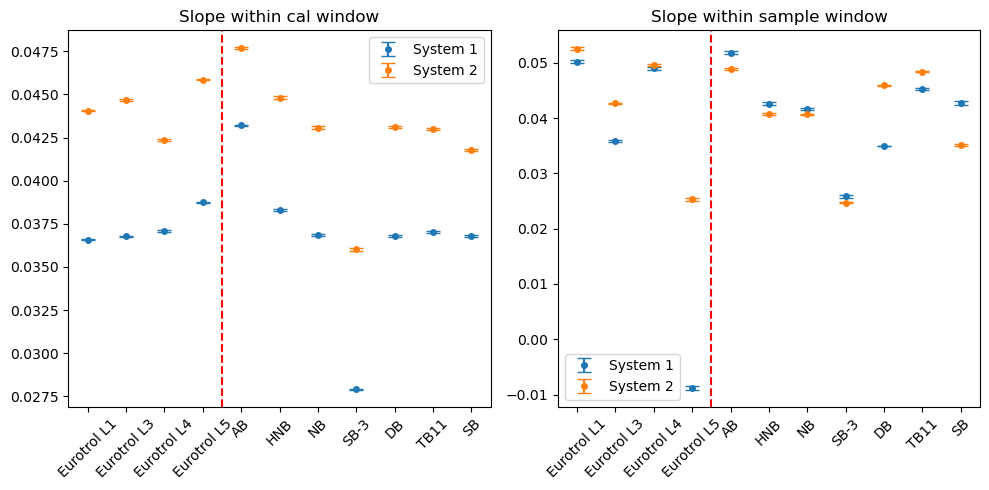

In [15]:
# Plot of slopes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-1-cal-slope"], yerr=Sensor_B_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-2-cal-slope"], yerr=Sensor_B_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-1-sample-slope"], yerr=Sensor_B_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-2-sample-slope"], yerr=Sensor_B_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

for ax in axes:
    ax.axvline(x=3.5, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [16]:
# T-tests to compare slopes in each bin
ttest_B = run_ttest(Sensor_B_slopes, N_B1_cal, N_B2_cal, N_B1_sample, N_B2_sample, labels)
ttest_B

/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stat_cal = (data["System-1-cal-slope"][i] - data["System-2-cal-slope"][i]) / np.sqrt(data["System-1-cal-se"][i]**2 + data["System-2-cal-se"][i]**2)
/Users/jessie_w/MDS/Capstone/Capstone_Siemens/Coding/Window_Optimization/Raw_Slope_New_Window/raw_slope_functions.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stat_sample = (data["System-1-sample-slope"][i] - data["System-2-sample-slope"][i]) / np.sqrt(data["System-1-sample-se"][i]**2 + data["Sys

,t-statistic-cal,p-value-cal,t-statistic-sample,p-value-sample
Eurotrol L1,-127.077933,0.0,-6.536419,6.717037e-08
Eurotrol L3,-131.753260,0.0,-36.798936,0.000000e+00
Eurotrol L4,-70.179419,0.0,-1.587128,1.199845e-01
Eurotrol L5,-108.479284,0.0,-77.142703,0.000000e+00
AB,-104.364504,0.0,13.222050,2.220446e-16
HNB,-66.155667,0.0,8.122553,3.775680e-10
NB,-66.365285,0.0,3.859299,3.855455e-04
SB-3,-95.342670,0.0,3.957726,2.861680e-04
DB,-74.448593,0.0,-172.331627,0.000000e+00
TB11,-71.474808,0.0,-15.252945,0.000000e+00
